In [15]:
import fastsemsim
import tables
import datasketch
import pickle 
import pyoma
import redis
import datasketch
from matplotlib import pyplot as plt
from goatools.semantic import resnik_sim
from goatools.semantic import lin_sim
from goatools.semantic import semantic_similarity
from goatools import obo_parser
from goatools.associations import read_gaf
from goatools.semantic import TermCounts, get_info_content
import multiprocessing as mp
import time
import gc

from multiprocessing import TimeoutError, Manager
from itertools import combinations
import numpy as np
import zlib



In [16]:

#heavy load of the lsh forest
forest = '/data/OMAanalysis/ForestALL.pkl'
with open(forest , 'r') as hashforest:
    lshforest= pickle.load(hashforest)


In [17]:
r = redis.StrictRedis(host='localhost', port=6379, db=0)


In [18]:

omadatalocation = '/data/databases/OMA/OMA.2.1.1/data/OmaServer.h5'
h5file = tables.open_file(omadatalocation, mode="r")


In [19]:

handle2= open('./rowdictReverse.pkl','r')
rowdictReverse = pickle.load(handle2)
handle2.close()

In [20]:
#load gene ontology DAG
#use guaranteed acyclic basic GO
go = obo_parser.GODag("/home/USERNAME/Dropbox/Dessimozlab/semanticSimilarity/ontology/go-basic.obo")

associations = read_gaf("/home/USERNAME/Dropbox/Dessimozlab/semanticSimilarity/ontology/gene_association.tair.gz")
# First get the counts of each GO term.
termcounts = TermCounts(go, associations)

load obo file /home/USERNAME/Dropbox/Dessimozlab/semanticSimilarity/ontology/go-basic.obo
/home/USERNAME/Dropbox/Dessimozlab/semanticSimilarity/ontology/go-basic.obo: fmt(1.2) rel(2018-01-07) 47,109 GO Terms
  READ 217,451 associations: /home/USERNAME/Dropbox/Dessimozlab/semanticSimilarity/ontology/gene_association.tair.gz


In [21]:
#these work
def _hog_lex_range( hog):
    hog_str = hog.decode() if isinstance(hog, bytes) else hog
    return hog_str.encode('ascii'), (hog_str[0:-1] + chr(1 + ord(hog_str[-1]))).encode('ascii')

def iterHOGMembers(odb,hog_id):
    hog_range = _hog_lex_range(hog_id)
    it = odb.root.Protein.Entries.where( '({!r} <= OmaHOG) & (OmaHOG < {!r})'.format(*hog_range))
    for row in it:
        yield row.fetch_all_fields()

def grabGOterms(odb,hog_id, maxEntries = 5000):
    iterator = iterHOGMembers(odb, hog_id)
   
    if maxEntries == None:
        population = frozenset( [x['EntryNr'] for x in iterator] )
    else:
        population = []
        for i,x in enumerate(iterator):
            if i > maxEntries:
                break
            population.append(x['EntryNr'])
        population = frozenset(population)
    
    #turn into godict
    godict = {entry: {('GO:{:07d}'.format(e['TermNr']),  # Make the GO:0000001 style ID again (GOATOOLS requires this)
                   str(e['Evidence']),      # Extract Evidence code
                   str(e['Reference']))     # Extract Reference code
                  for e in odb.root.Annotations.GeneOntology.read_where('EntryNr == {}'.format(entry))   } for entry in population}
    cpt = sum([1 for a in godict.values() if a == set()])    
    return godict, cpt


def retprotEntry(odb, entry_nr):
    entry = odb.root.Protein.Entries.read_where('EntryNr == {}'.format(entry_nr))
    if len(entry) != 1:
        raise ValueError("there are {} entries with entry_nr {}".format(len(entry), entry_nr))
    entry = entry[0]
    return entry

def retprotEntryFromCanonical(odb, CanonicalId):
    #doesnt work yet
    
    entry = odb.root.Protein.Entries.read_where('CanonicalId == {}'.format(CanonicalId) )
    if len(entry) != 1:
        raise ValueError("there are {} entries with CanonicalId {}".format(len(entry), CanonicalId))
    entry = entry[0]
    return entry

def grabSequences(odb, hog_id):
    iterator = iterHOGMembers(odb, hog_id)
    #grab all oma IDs
    seqArr = odb.get_node('/Protein/SequenceBuffer')
    seqdict={}
    for x in iterator:
        if x['EntryNr'] not in seqdict:
            entry = retprotEntry(odb,x['EntryNr'])
            seqdict[x['EntryNr']] = seqArr[entry['SeqBufferOffset']:entry['SeqBufferOffset'] + entry['SeqBufferLength'] - 1].tostring()
    return seqdict


In [22]:

qhog = 'HOG:0385024'
godict, cpt= grabGOterms(h5file,qhog)
seqdict = grabSequences(h5file, qhog)
print godict
print len(godict)


/usr/local/lib/python2.7/dist-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/Protein/_i_Entries/OmaHOG/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


{10974848: set([('GO:0016021', 'IEA', 'OMA_Fun:001')]), 10114433: set([('GO:0016021', 'IEA', 'GO_REF:038'), ('GO:0016020', 'IEA', 'GO_REF:038')]), 6002178: set([]), 9976840: set([('GO:0016021', 'IEA', 'GO_REF:038'), ('GO:0016020', 'IEA', 'GO_REF:038')]), 11174282: set([('GO:0016021', 'IEA', 'OMA_Fun:001')]), 11155083: set([('GO:0005886', 'IEA', 'GO_REF:107'), ('GO:0048235', 'IEA', 'GO_REF:107'), ('GO:0005783', 'IEA', 'GO_REF:107'), ('GO:0016021', 'IEA', 'GO_REF:038'), ('GO:0016020', 'IEA', 'GO_REF:038')]), 10980251: set([('GO:0016021', 'IEA', 'GO_REF:038'), ('GO:0016020', 'IEA', 'GO_REF:038')]), 10043778: set([('GO:0016021', 'IEA', 'GO_REF:038'), ('GO:0016020', 'IEA', 'GO_REF:038')]), 5945103: set([]), 10056468: set([('GO:0016021', 'IEA', 'OMA_Fun:001')]), 5717269: set([]), 10225175: set([('GO:0016021', 'IEA', 'GO_REF:038'), ('GO:0016020', 'IEA', 'GO_REF:038')]), 11393305: set([]), 10127131: set([('GO:0016021', 'IEA', 'OMA_Fun:001')]), 10809757: set([('GO:0016021', 'IEA', 'GO_REF:038')

In [23]:
#this works
def resnik(annot1, annot2):
    #calculate the max GO similarity with two metrics
    maxresnik = 0
    for gotuple1 in annot1:
        for gotuple2 in annot2:
            goterm1,evid1,omacode1 = gotuple1
            goterm2,evid2,omacode2 = gotuple2
            try:
                resnik = resnik_sim(goterm1, goterm2, go, termcounts)
            except:
                passOKannotations = ['EXP', 'IMP', 'IGI', 'IPI', 'IEP', 'IDA']

            if resnik>maxresnik:
                    maxresnik = resnik
    return maxresnik

def lin(annot1, annot2):
    #calculate the max GO similarity with two metrics
    maxresnik = 0
    for gotuple1 in annot1:
        for gotuple2 in annot2:
            goterm1,evid1,omacode1 = gotuple1
            goterm2,evid2,omacode2 = gotuple2
            lin = lin_sim(goterm1, goterm2, go, termcounts)
            if lin != None and -lin>maxresnik:
                maxresnik = -lin
    return  maxresnik

def GOdist(godict1,godict2, semfunction):
    
    go1 = godict1
    go2 = godict2
    resnikMat = np.zeros( ( len(godict1) , len(godict2) ) ) 

    godists={}
    for j,key2 in enumerate(go2.keys()):
        for i,key1 in enumerate(go1.keys()):
            l1 = go1[key1]
            l2 = go2[key2]
            dist = semfunction(l1,l2)
            resnikMat[i,j]= dist
    return resnikMat 
    

In [24]:


goterms1 = set([('GO:0005886', 'IEA', 'GO_REF:107'), ('GO:0048235', 'IEA', 'GO_REF:107'), ('GO:0005783', 'IEA', 'GO_REF:107'), ('GO:0016021', 'IEA', 'GO_REF:038'), ('GO:0016020', 'IEA', 'GO_REF:038')])
goterms2 = set([('GO:0016021', 'IEA', 'GO_REF:038'), ('GO:0016020', 'IEA', 'GO_REF:038')])
maxresnik = resnik(goterms1,goterms2)
print maxresnik
maxresnik = lin(goterms1,goterms2)
print maxresnik


4.01596913305
1.0


In [25]:
#to deal with distance matrix between go term corpuses

def NonZeroAvg(resnikMat):
    #The average score between the annotation corpuses of two Hogs without counting proteins with no annotation
    
    indices = np.where(resnikMat > 0 )
    mean = np.mean(resnikMat[indices])
    if np.isnan(mean) == True:
        mean = 0 
    return mean

def retMax(resnikMat):
    #The max score between two corpuses of two hogs
    return np.amax(resnikMat)



HOG:0374514


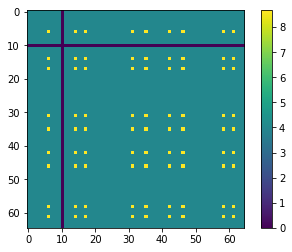

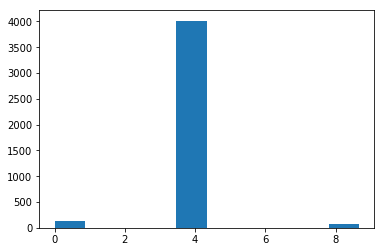

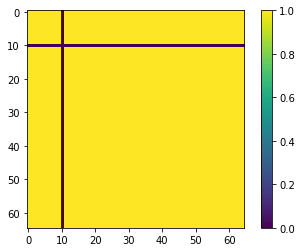

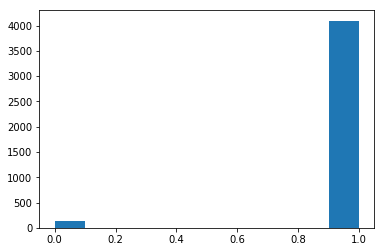

HOG:0385024


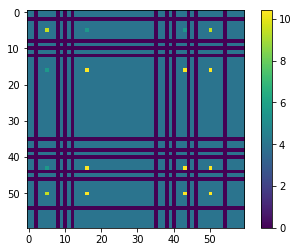

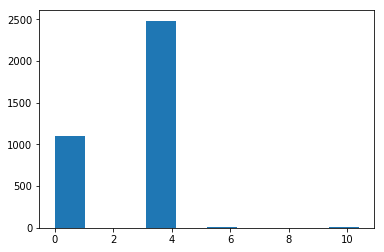

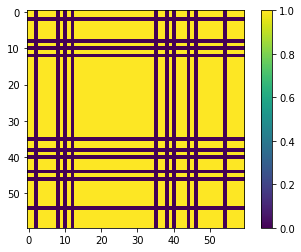

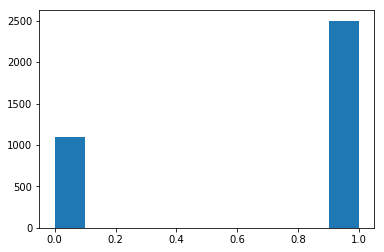

HOG:0262715


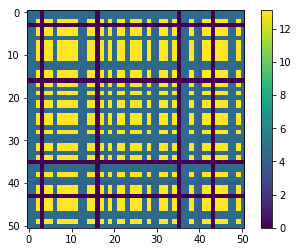

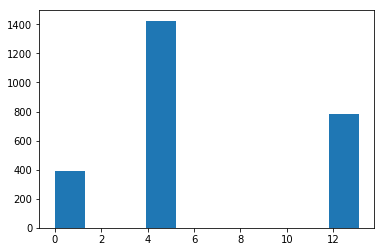

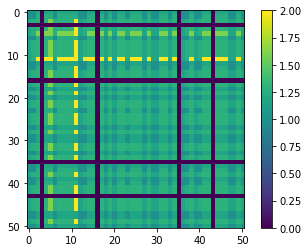

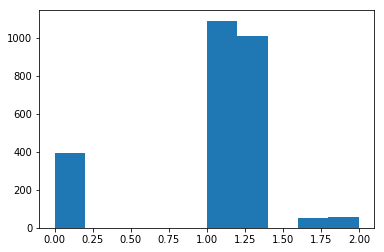

HOG:0374514
HOG:0385024


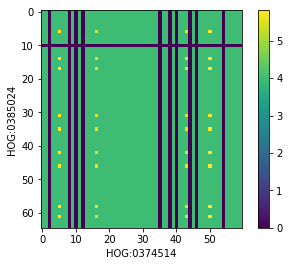

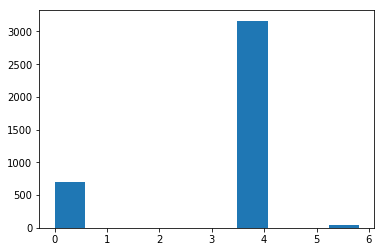

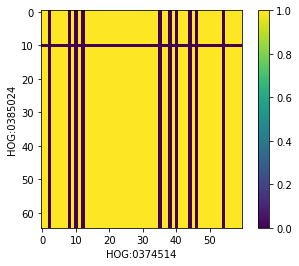

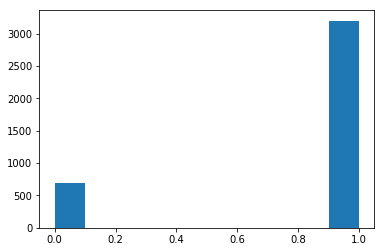

HOG:0374514
HOG:0262715


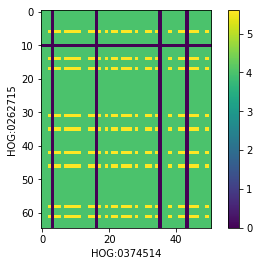

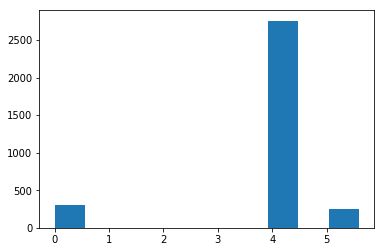

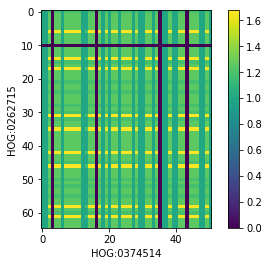

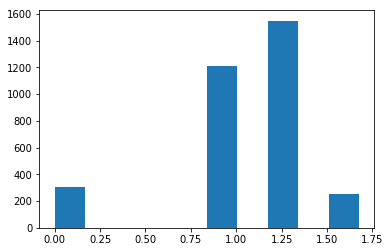

HOG:0385024
HOG:0262715


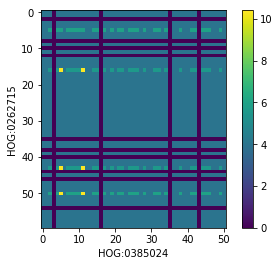

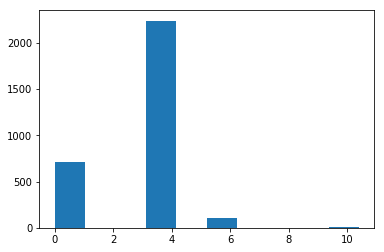

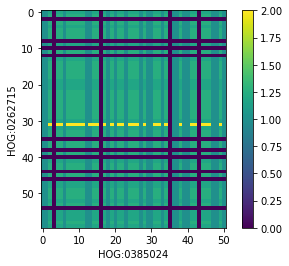

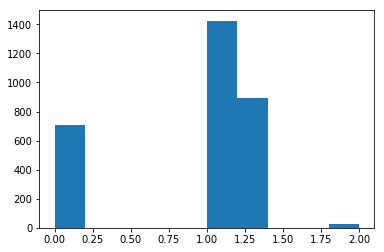

In [29]:

from itertools import combinations

for qhog in ['HOG:0374514' , 'HOG:0385024', 'HOG:0262715']:

    print qhog
    #get a hog from a gene. useful for ppi and string stuff
    godict, cpt= grabGOterms(h5file,qhog)
    seqdict = grabSequences(h5file, qhog)

    resnikMat = GOdist(godict,godict,resnik)

    plt.imshow(resnikMat)
    plt.colorbar()
    plt.show()

    plt.hist(resnikMat.flatten())
    plt.show()

    resnikMat = GOdist(godict,godict,lin)

    plt.imshow(resnikMat)
    plt.colorbar()
    plt.show()

    plt.hist(resnikMat.flatten())
    plt.show()


for qhog1, qhog2 in combinations(['HOG:0374514' , 'HOG:0385024', 'HOG:0262715'], 2):
    print qhog1
    print qhog2
    
    
    #get a hog from a gene. useful for ppi and string stuff
    godict1, cpt= grabGOterms(h5file,qhog1)
    seqdict2 = grabSequences(h5file, qhog1)
    godict2, cpt= grabGOterms(h5file,qhog2)
    seqdict2 = grabSequences(h5file, qhog2)
    resnikMat = GOdist(godict1,godict2,resnik)
    
    plt.imshow(resnikMat)
    plt.ylabel(qhog2)
    plt.xlabel(qhog1)
    plt.colorbar()
    plt.show()

    plt.hist(resnikMat.flatten())
    plt.show()

    resnikMat = GOdist(godict1,godict2,lin)

    plt.imshow(resnikMat)
    plt.ylabel(qhog2)
    plt.xlabel(qhog1)
    plt.colorbar()
    plt.show()

    plt.hist(resnikMat.flatten())
    plt.show()
    

In [ ]:
#compression distance between two strings
def KomolgrovUpper(str1,str2):
    ka = len(zlib.compress(str1))
    kb = len(zlib.compress(str2))
    kab = len(zlib.compress(str1+str2))
    return float(kab)/max(ka,kb) 

def MIRows( row1, row2 , mapping = None):
#MI between two rows of a scipy sparse matrix
#depends on find function from scipy sparse

    row1 =find(row1)[0]
    row2 = find(row2)[0]
    if mapping == 'species':
        taxIDs1 = np.vectorize(coldictReverse.get)(row1)
        taxIDs2 = np.vectorize(coldictReverse.get)(row2)
        taxa2 = np.vectorize(IdtoName.get)(taxIDs2)
        taxa1 = np.vectorize(IdtoName.get)(taxIDs1)
        str1=np.array2string(taxa1)
        str2=np.array2string(taxa2)
    else:
        taxIDs1 = np.vectorize(coldictReverse.get)(row1)
        taxIDs2 = np.vectorize(coldictReverse.get)(row2)
        str1=np.array2string(taxIDs1)
        str2=np.array2string(taxIDs2)
    return KomolgrovUpper(str1,str2)


In [30]:
#BUILD TESTING DATASET //////////////////////////////////////////////////////////////
#500 search results for each
finalset = {}
#Filter for annotation quality... and number of sequences
#for now at least 10 annotations
#grab sequence data

print rowdictReverse[1917999]
godict, cpt = grabGOterms(h5file,rowdictReverse[1917999])
OKannotations = ['EXP', 'IMP', 'IGI', 'IPI', 'IEP', 'IDA']


HOG:0588760.24r.145a.131c


In [31]:
import signal
from contextlib import contextmanager

class TimeoutException(Exception): pass

@contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)


    

In [32]:
def build_dict(args):
    finalset = {}
    row, lshforest, r ,k = args
    godict, cpt = grabGOterms(h5file,rowdictReverse[row])
    sequences = grabSequences(h5file,rowdictReverse[row])
    hashval = pickle.loads(r.get(row))
    finalset[rowdictReverse[row]]= { 'row':row, 'godict':godict , 'cpt':cpt , 'hash': hashval ,'sequences': sequences , 'LSHresults' : lshforest.query(hashval , k ) }
    return finalset

k = 100 

randomset = list( np.random.randint(0,len(rowdictReverse),5)   )
print randomset

final = {}
for row in randomset:
    final.update(build_dict((row , lshforest, r , k )))

#print final

[518388, 2053897, 241806, 200304, 498196]


In [33]:
def maker_workerfunction_Results(rowdictReverse, h5file, lshforest, r ,k , OKannotations = set(['EXP', 'IMP', 'IGI', 'IPI', 'IEP', 'IDA', 'IEA']) ):
    def workerfunction(row , lock):
        lock.acquire()
        godict, cpt = grabGOterms(h5file,rowdictReverse[row])
        lock.release()
        qualitycheck= False
        
        #check at least one of the annotations is good 
        """for note in godict.values():
            for tupl in note:
                if set(tupl).intersection(OKannotations) > 0:            
                    qualitycheck = True
                    break
            if qualitycheck == True:
                break
        
        if qualitycheck == True:"""
        hashval = pickle.loads(r.get(row))
        #lock.acquire()
        #sequences = grabSequences(h5file,rowdictReverse[row])
        #lock.release()
        results = lshforest.query(hashval , k )
        


        finalset = { 'row':row, 'HOG':rowdictReverse[int(row)] , 'godict':godict , 'cpt':cpt , 'hash': hashval , 'LSHresults' : results }

        return finalset
    return workerfunction

def maker_workerfunction_Godist( rowdictReverse, h5file, r ):
    def workerfunction(dictentry , lock):
        dataset = {}
        for row in dictentry['LSHresults']:
            HOGname = rowdictReverse[int(row)]
            lock.acquire()
            #sequences = grabSequences(h5file,HOGname)
            godict, cpt = grabGOterms(h5file,HOGname)
            lock.release()
            
            
            hashval = pickle.loads(r.get(row))
            
            jaccardscore = dictentry['hash'].jaccard(hashval)
            #MIscore =  KomolgrovUpper(''.join(dictentry['sequences'].values()),''.join(sequences.values()))
            linmat = GOdist(godict, dictentry['godict'], lin)
            resnikmat =  GOdist(godict, dictentry['godict'], resnik)
            
            dataset[( HOGname , rowdictReverse[dictentry['row']]) ] = { 'jaccard': jaccardscore ,  'LinAvg': NonZeroAvg(linmat) , 'linMax':retMax(linmat) ,
                                         'ResnikAvg': NonZeroAvg(resnikmat), 'ResnikMax':retMax(resnikmat)  }
        
        
        return dataset
    return workerfunction

def both(worker_res, worker_dist):
    def retboth (row,l ):
        return worker_dist(worker_res(row,l) , l )
    return retboth

def updatefunction(startobject, update_data):
    #for a dictionary
 
    try:
        startobject.update(update_data)
    except:
        print update_data
    return startobject

def datagen_dict( dictionary):
    for entry in dictionary:
        yield dictionary[entry]

In [34]:

np.random.seed(seed = 0)
rando = iter( list(np.random.randint(0,len(rowdictReverse),1500)))

final = {}"""
for i in range(10):
    print i
    try:
        with time_limit(20):
            final.update( bothfunctions( next(rando) , l ))
    except TimeoutException as e:
            print("Timed out!")
            
print final"""

SyntaxError: invalid syntax (<ipython-input-34-c32380ef08f6>, line 21)

In [73]:

def worker(i,q,retq,l, timecards , workerfunction  ):
    pnumber = i
    timecards[ pnumber ] = time.time()
    while True:
        timecards[ pnumber ] = time.time()
        time.sleep(.1)
        data = q.get()
        completed = False
        if data == 'DONE':
            break 
        try:
            with time_limit(20):
                update_data = workerfunction(data , l)
                completed = True
        except TimeoutException as e:
            print("Timed out!")
        
        gc.collect()
        if completed == True:
            retq.put(update_data)
            print("updating!")
        #punch the clok.
        #timecards[ pnumber ] = time.time()
        

def updater(i,q,retq,l , updatefunction ,startobject, saveobject ):
    pnumber = i
    while True:
        time.sleep(.1)
        update_data = retq.get()
        if update_data == 'DONE':
            break
        else :
            print 'update'            
            startobject = updatefunction(startobject , update_data)
            l.acquire()
            handle1=open(saveobject , 'w')
            pickle.dump(startobject, handle1 , -1)
            handle1.close()
            print'object saved'
            l.release()
    
    
    

In [74]:
def mp_with_timeout(nworkers, nupdaters, startobject , saveobject , datagenerator , workerfunction, updatefunction, timeout = 60, saveinterval = 600  ):

    wprocesses ={}
    uprocesses ={}    
    l = mp.Lock()
    cores = mp.cpu_count()
    q = mp.Queue( maxsize = cores*10 )
    retq = mp.Queue( maxsize = cores*10 )
    
    #30sec timetout for workers
    manager = Manager()
    timecards = manager.dict()

    for i in range(nworkers):
        t = mp.Process(target=worker, args=(i,q,retq,l, timecards , workerfunction )  ) 
        t.daemon = True
        t.start()
        wprocesses[i] = t


    for i in range(nupdaters):
        t = mp.Process(target=updater, args=(i,q,retq,l , updatefunction ,startobject , saveobject+str(i)+'.pkl'  ) ) 
        t.daemon = True
        t.start()
        uprocesses[i]= t

    count =0
    data = next(datagenerator)
    start = time.time()
    
    while True:
        time.sleep(.1)
        #check for non responsive workers
        #save every so often
        if count % 100 == 0 :
            retq.put('SAVE')
        try:
            data = next(datagenerator)
            q.put(data)
            count += 1
        except StopIteration:
            
            print 'stop iteration'
            for p in range(nworkers):
                q.put('DONE')
                
            
            for p in range(nupdaters):
                retq.put('DONE')
            break

        if count % 100 == 0:
            print count
            retq.put('SAVE')
    
    for p in wprocesses:
        wprocesses[p].terminate()
    gc.collect()
    for p in uprocesses:
        uprocesses[p].terminate()
    gc.collect()
    print 'DONE!!!!!'

def singlecore(  startobject, workerfunction , updatefunction , saveobject, Lock):
    for i, dataobject in enumerate(datagenerator):
        if i < 10:
            print i
            print dataobject
        if i %100 == 0 and i > 0:
            print i 
        if i % 200 == 0 and i > 0:
            print 'saving'
            with open( saveobject , 'w') as handle:
                pickle.dump(handle)
        update = workerfunction(dataobject,Lock)
        startobject = updatefunction(startobject , update) 
    with open( saveobject , 'w') as handle:
        pickle.dump(startobject, handle , -1)


In [76]:
nworkers = 10
nupdaters = 1

startobject = {}
saveobject = './random_results'

k = 30
workerfunction = maker_workerfunction_Results(rowdictReverse, h5file, lshforest, r ,k )
datasetworker = maker_workerfunction_Godist( rowdictReverse, h5file, r )

bothfunctions = both(workerfunction, datasetworker ) 

#choose 10k random HOGS
np.random.seed(seed = 0)
randomset = list(np.random.randint(0,len(rowdictReverse),1500))
datagenerator = iter(randomset)
#singlecore(  startobject, workerfunction , updatefunction , saveobject, Lock)
mp_with_timeout(nworkers, nupdaters , startobject , saveobject , datagenerator ,bothfunctions , updatefunction )

update
SAVE
object saved


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwa

update
SAVE
100
object saved
update
SAVE
object saved
updating!
update
object saved
updating!
update
object saved
updating!
update
object saved
updating!
update
object saved
updating!
update
updating!
object saved
update
object saved
update
updating!
object saved
updating!
update
object saved
update
updating!
object saved
update
updating!
updating!
updating!
object saved
update
updating!
object saved
update
object saved
update
object saved
updating!
update
object saved
updating!
update
updating!
object saved
update
object saved
Timed out!
Timed out!
Timed out!
Timed out!
Timed out!
Timed out!
Timed out!
Timed out!
Timed out!
Timed out!
Timed out!
Timed out!
Timed out!
Timed out!


Process Process-180:
Process Process-171:
Process Process-172:
Traceback (most recent call last):
Process Process-174:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process Process-175:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "<ipython-input-73-63bea968c92a>", line 14, in worker
    self.run()
    self.run()
    sel

KeyboardInterrupt: 

    update_data = workerfunction(data , l)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "<ipython-input-73-63bea968c92a>", line 14, in worker
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-33-20f8027ec037>", line 58, in retboth
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-73-63bea968c92a>", line 14, in worker
  File "<ipython-input-73-63bea968c92a>", line 31, in updater
    self._target(*self._args, **self._kwargs)
    update_data = workerfunction(data , l)
  File "<ipython-input-33-20f8027ec037>", line 58, in retboth
    return worker_dist(worker_res(row,l) , l )
    update_data = retq.get()
  File "<ipython-input-73-63bea968c92a>", line 14, in worker
  File "<ipython-input-33-20f8027ec037>", line 3, in workerfunction
    update_data = workerfunction(data , l)
    lock.acquire()
KeyboardInterrupt
    update_data = workerfunction(data

In [ ]:
nworkers = 10
nupdaters = 1

datasetworker = maker_workerfunction_Godist( rowdictReverse, h5file, r )
startobject = {}
saveobject = './random_results_mat'

with open( './random_results0.pkl' , 'r') as handle:
    results = pickle.load(handle)
print len(results)
#choose 10k random HOGS
np.random.seed(seed = 0)

l = mp.Lock()
datagenerator = datagen_dict(results)
startobject = {}



#singlecore(startobject, datasetworker , updatefunction , saveobject , l)

In [29]:
mp_with_timeout(nworkers, nupdaters , startobject , saveobject , datagenerator ,workerfunction , updatefunction )

Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 268, in _feed
    send(obj)
IOError: [Errno 32] Broken pipe


stop iteration


IOError: [Errno 32] Broken pipe
Process Process-72:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-18-d29483810dea>", line 28, in updater
    update_data = retq.get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 117, in get
    res = self._recv()
KeyboardInterrupt


KeyboardInterrupt: 

In [90]:
import pandas as pd
with open( './random_results0.pkl' , 'r') as handle:
    results = pickle.load(handle)
finaldataframe = pd.DataFrame.from_dict(results).transpose()
print finaldataframe

                                                                                                   LinAvg  \
HOG:0010549.1b                                     HOG:0020382.1a                                0.000000   
HOG:0010684.1b                                     HOG:0020382.1a                                0.000000   
HOG:0010801.1b                                     HOG:0020382.1a                                0.000000   
HOG:0010837.1c                                     HOG:0020382.1a                                0.875923   
HOG:0010915.1a                                     HOG:0020382.1a                                0.000000   
HOG:0011111.1a                                     HOG:0020382.1a                                0.000000   
HOG:0012349.2a                                     HOG:0020382.1a                                0.000000   
HOG:0012457.3b                                     HOG:0020382.1a                                0.000000   
HOG:0012592.1f     

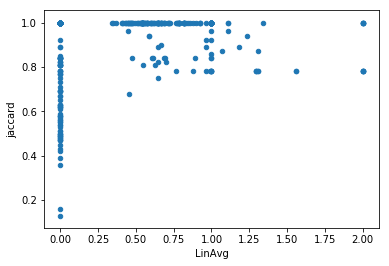

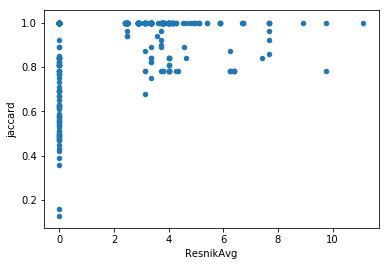

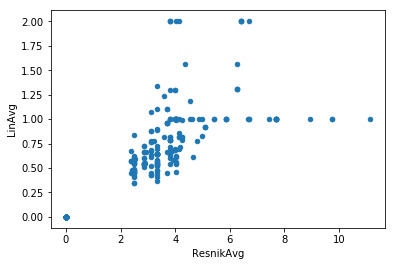

In [96]:
finaldataframe.plot.scatter(x = 'LinAvg' , y = 'jaccard')

finaldataframe.plot.scatter(x = 'ResnikAvg' , y = 'jaccard')
plt.show()

finaldataframe.plot.scatter(x = 'ResnikAvg' , y = 'LinAvg')
plt.show()


In [ ]:



#use tensorflow regressor to predict the resnik distance between profiles
#generate dataset: rownumber, rownumber query, jaccard, seqMI, resnik




In [ ]:
print h5file.root.Protein.Entries.description